In [1]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
bt = sqlContext.read.format("org.apache.spark.sql.cassandra").load(table="bt_sensors", keyspace="dice")
bt1 = bt

In [2]:
bt = bt1

In [2]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DateType

timestampTokens = udf(lambda a, b: a + (b - a)/2, DateType())
bt = bt.withColumn('timestamp', timestampTokens(bt.timestampfrom, bt.timestampto))
hourTokens = udf(lambda time: time.hour, IntegerType())
bt = bt.withColumn('hour', hourTokens(bt.timestamp))
minuteTokens = udf(lambda time: time.minute, IntegerType())
bt = bt.withColumn('minute', minuteTokens(bt.timestamp))
weekTokens = udf(lambda time: time.weekday(), IntegerType())
bt = bt.withColumn('weekday', weekTokens(bt.timestamp))

In [6]:
bt.printSchema()
bt.show()

root
 |-- id: string (nullable = true)
 |-- timestampto: timestamp (nullable = true)
 |-- allcount: integer (nullable = true)
 |-- avgspeed: float (nullable = true)
 |-- avgtraveltime: float (nullable = true)
 |-- count: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- frombtid: string (nullable = true)
 |-- frombtlat: float (nullable = true)
 |-- frombtlng: float (nullable = true)
 |-- timestampfrom: timestamp (nullable = true)
 |-- tobtid: string (nullable = true)
 |-- tobtlat: float (nullable = true)
 |-- tobtlng: float (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- weekday: integer (nullable = true)

+--------------------+--------------------+--------+---------+-------------+-----+--------+--------+---------+---------+--------------------+-------+--------+--------+----------+----+------+-------+
|                  id|         timestampto|allcount| avgspeed|avgtraveltime

In [3]:
bt = bt.select('avgspeed', 'count', 'frombtid', 'tobtid', 'hour', 'minute', 'weekday').where('count > 10')

In [4]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="frombtid", outputCol="frombtid_numeric").fit(bt)
bt = indexer.transform(bt)
indexer = StringIndexer(inputCol="tobtid", outputCol="tobtid_numeric").fit(bt)
bt = indexer.transform(bt)

In [5]:
bt = bt.drop('frombtid').drop('tobtid')

In [10]:
bt.show()

+---------+-----+----+------+-------+----------------+--------------+
| avgspeed|count|hour|minute|weekday|frombtid_numeric|tobtid_numeric|
+---------+-----+----+------+-------+----------------+--------------+
|37.055862|   22|  19|    42|      1|             1.0|           5.0|
|  30.8481|   20|  11|    12|      3|             0.0|           4.0|
| 52.89707|   14|  21|    27|      6|             1.0|           5.0|
| 51.80975|   12|   6|    12|      2|             8.0|           2.0|
|36.888073|   14|  16|    42|      4|             2.0|          10.0|
|42.545383|   13|   8|    57|      5|             0.0|           3.0|
|28.202934|   15|  19|    12|      4|             8.0|           2.0|
|  34.1296|   20|  14|    42|      3|             2.0|           6.0|
|29.615538|   13|   8|    42|      4|             8.0|           2.0|
| 40.86261|   18|  12|    42|      1|             5.0|           3.0|
|20.360428|   14|   7|    42|      3|             8.0|           2.0|
|32.992386|   13|  1

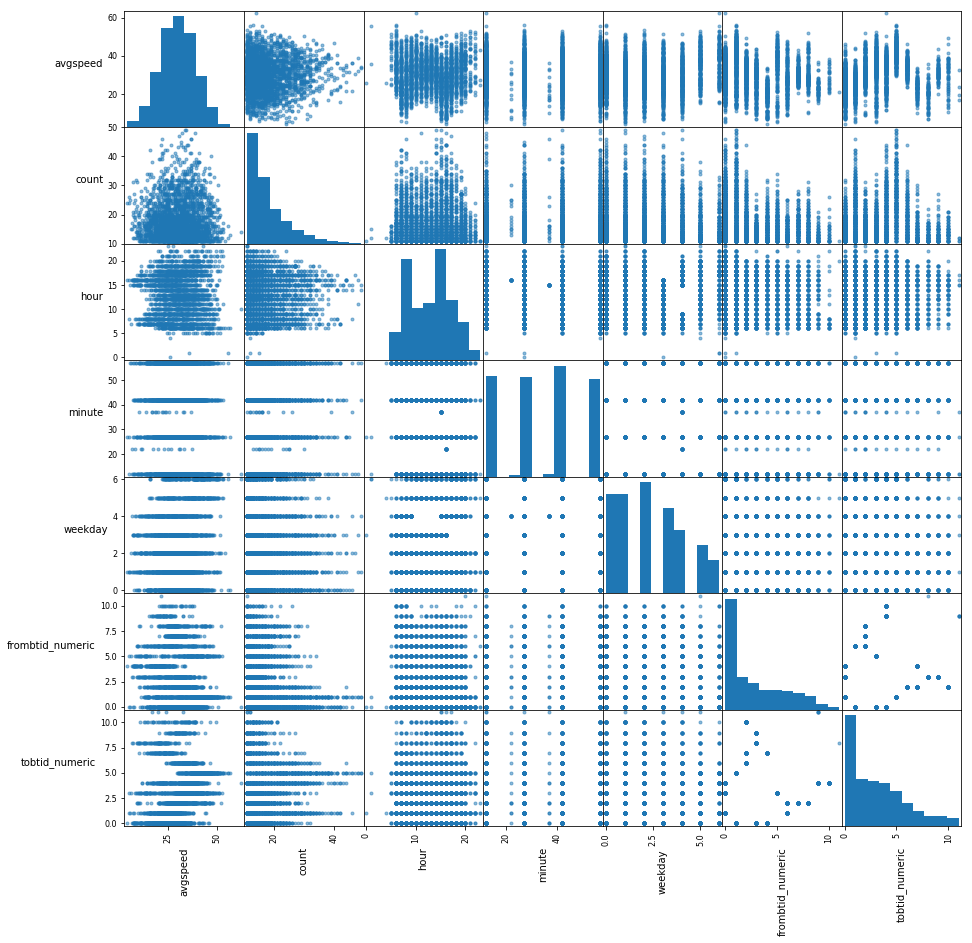

In [6]:
%matplotlib inline
import pandas as pd

sampled_data = bt.toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(15, 15));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)

In [6]:
from pyspark.ml.feature import VectorAssembler
not_use = ['avgspeed', 'count']
assembler = VectorAssembler(inputCols=[x for x in bt.columns if x not in not_use], outputCol='features')
bt = assembler.transform(bt)

In [7]:
train, test = bt.randomSplit([0.7, 0.3], 1234)

In [12]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(maxDepth=30, maxBins=50, minInstancesPerNode=25, labelCol='avgspeed')
model = dt.fit(train) #rmse=0.495445

In [12]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import itertools
from tqdm import tqdm_notebook

best = []

comb = list(itertools.product([30], range(32,50,1), range(1,10,1)))

for c in tqdm_notebook(comb):
    dt = DecisionTreeRegressor(maxDepth=c[0], maxBins=c[1], minInstancesPerNode=c[2], labelCol='avgspeed')
    model = dt.fit(train)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(labelCol="avgspeed", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    best.append((rmse, c))

In [13]:
sorted(best)

[(4.762472568343025, (30, 32, 5)),
 (4.762472568343025, (30, 33, 5)),
 (4.762472568343025, (30, 34, 5)),
 (4.762472568343025, (30, 35, 5)),
 (4.762472568343025, (30, 36, 5)),
 (4.762472568343025, (30, 37, 5)),
 (4.762472568343025, (30, 38, 5)),
 (4.762472568343025, (30, 39, 5)),
 (4.813956172249067, (30, 40, 8)),
 (4.813956172249067, (30, 41, 8)),
 (4.813956172249067, (30, 42, 8)),
 (4.813956172249067, (30, 43, 8)),
 (4.813956172249067, (30, 44, 8)),
 (4.813956172249067, (30, 45, 8)),
 (4.813956172249067, (30, 46, 8)),
 (4.813956172249067, (30, 47, 8)),
 (4.813956172249067, (30, 48, 8)),
 (4.813956172249067, (30, 49, 8)),
 (4.817907433456466, (30, 40, 7)),
 (4.817907433456466, (30, 41, 7)),
 (4.817907433456466, (30, 42, 7)),
 (4.817907433456466, (30, 43, 7)),
 (4.817907433456466, (30, 44, 7)),
 (4.817907433456466, (30, 45, 7)),
 (4.817907433456466, (30, 46, 7)),
 (4.817907433456466, (30, 47, 7)),
 (4.817907433456466, (30, 48, 7)),
 (4.817907433456466, (30, 49, 7)),
 (4.840379595649406,

In [93]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(maxDepth=20, maxBins=30, minInstancesPerNode=5, numTrees=30, labelCol='avgspeed')
model = rf.fit(train) #rmse=0.490043

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator
predictions = model.transform(test)
evaluator = RegressionEvaluator(labelCol="avgspeed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.467726
